### Predicting Customer Churn in Telco

In this notebook you will learn how to build a predictive model with Spark machine learning API (SparkML) and deploy it for scoring in Machine Learning (ML). 

This notebook walks you through these steps:
- Build a model with SparkML API
- Save the model in the ML repository
- Create a Deployment in ML (via UI)
- Test the model (via UI)
- Test the model (via REST API)

### Use Case

The analytics use case implemented in this notebook is telco churn. While it's a simple use case, it implements all steps from the CRISP-DM methodolody, which is the recommended best practice for implementing predictive analytics. 
![CRISP-DM](https://raw.githubusercontent.com/yfphoon/dsx_demo/master/crisp_dm.png)

The analytics process starts with defining the business problem and identifying the data that can be used to solve the problem. For Telco churn, we use demographic and historical transaction data. We also know which customers have churned, which is the critical information for building predictive models. In the next step, we use visual APIs for data understanding and complete some data preparation tasks. In a typical analytics project data preparation will include more steps (for example, formatting data or deriving new variables). 

Once the data is ready, we can build a predictive model. In our example we are using the SparkML Random Forrest classification model. Classification is a statistical technique which assigns a "class" to each customer record (for our use case "churn" or "no churn"). Classification models use historical data to come up with the logic to predict "class", this process is called model training. After the model is created, it's usually evaluated using another data set. 

Finally, if the model's accuracy meets the expectations, it can be deployed for scoring. Scoring is the process of applying the model to a new set of data. For example, when we receive new transactional data, we can score the customer for the risk of churn.  

We also developed a sample Python Flask application to illustrate deployment: http://predictcustomerchurn.mybluemix.net/. This application implements the REST client call to the model.

### Working with Notebooks

If you are new to Notebooks, here's a quick overview of how to work in this environment.

1. To run the notebook, it must be in the Edit mode. If you don't see the menu in the notebook, then it's not in the edit mode. Click on the pencil icon.
2. The notebook has 2 types of cells - markdown (text) and code. 
3. Each cell with code can be executed independently or together (see options under the Cell menu). When working in this notebook, we will be running one cell at a time because we need to make code changes to some of the cells.
4. To run the cell, position cursor in the code cell and click the Run (arrow) icon. The cell is running when you see the * next to it. Some cells have printable output.
5. Work through this notebook by reading the instructions and executing code cell by cell. Some cells will require modifications before you run them. 

### Step 1: Get Data

In [2]:
#Run once to install the wget package
!pip install wget

  Running setup.py bdist_wheel for wget ... done
  Stored in directory: /home/spark/shared/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [3]:
import wget
url_churn='https://raw.githubusercontent.com/yfphoon/dsx_demo/master/data/customer_churn/churn.csv'
url_customer='https://raw.githubusercontent.com/yfphoon/dsx_demo/master/data/customer_churn/customer.csv'

#remove existing files before downloading
!rm -f churn.csv
!rm -f customer.csv

churnFilename=wget.download(url_churn)
customerFilename=wget.download(url_customer)

!ls -l churn.csv
!ls -l customer.csv

-rw-r--r-- 1 spark spark 20079 Oct 12 07:05 churn.csv
-rw-r--r-- 1 spark spark 279541 Oct 12 07:05 customer.csv


### Step 2: Load data 

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

customer_churn= spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .option("inferSchema", "true")\
  .load("churn.csv")

customer = spark.read\
    .format("org.apache.spark.sql.execution.datasources.csv.CSVFileFormat")\
    .option("header", "true")\
    .option("inferSchema", "true")\
    .load("customer.csv")
    
customer.take(5)

[Row(ID=1, Gender='F', Status='S', Children=1.0, Est Income=38000.0, Car Owner='N', Age=24.393333, LongDistance=23.56, International=0.0, Local=206.08, Dropped=0.0, Paymethod='CC', LocalBilltype='Budget', LongDistanceBilltype='Intnl_discount', Usage=229.64, RatePlan=3.0),
 Row(ID=6, Gender='M', Status='M', Children=2.0, Est Income=29616.0, Car Owner='N', Age=49.426667, LongDistance=29.78, International=0.0, Local=45.5, Dropped=0.0, Paymethod='CH', LocalBilltype='FreeLocal', LongDistanceBilltype='Standard', Usage=75.29, RatePlan=2.0),
 Row(ID=8, Gender='M', Status='M', Children=0.0, Est Income=19732.8, Car Owner='N', Age=50.673333, LongDistance=24.81, International=0.0, Local=22.44, Dropped=0.0, Paymethod='CC', LocalBilltype='FreeLocal', LongDistanceBilltype='Standard', Usage=47.25, RatePlan=3.0),
 Row(ID=11, Gender='M', Status='S', Children=2.0, Est Income=96.33, Car Owner='N', Age=56.473333, LongDistance=26.13, International=0.0, Local=32.88, Dropped=1.0, Paymethod='CC', LocalBilltype

If the first step ran successfully (you saw the output), then continue reviewing the notebook and running each code cell step by step. Note that not every cell has a visual output. The cell is still running if you see a * in the brackets next to the cell. 

If the first step didn't finish successfully, check with the instructor. 

### Step 3: Merge Files

In [5]:
data=customer.join(customer_churn,customer['ID']==customer_churn['ID']).select(customer['*'],customer_churn['CHURN'])

### Step 4: Rename some columns
This step is to remove spaces from columns names, it's an example of data preparation that you may have to do before creating a model. 

In [6]:
data = data.withColumnRenamed("Est Income", "EstIncome").withColumnRenamed("Car Owner","CarOwner")
data.toPandas().head()

,ID,Gender,Status,Children,EstIncome,CarOwner,Age,LongDistance,International,Local,Dropped,Paymethod,LocalBilltype,LongDistanceBilltype,Usage,RatePlan,CHURN
0,1,F,S,1.0,38000.00,N,24.393333,23.56,0.0,206.08,0.0,CC,Budget,Intnl_discount,229.64,3.0,T
1,6,M,M,2.0,29616.00,N,49.426667,29.78,0.0,45.50,0.0,CH,FreeLocal,Standard,75.29,2.0,F
2,8,M,M,0.0,19732.80,N,50.673333,24.81,0.0,22.44,0.0,CC,FreeLocal,Standard,47.25,3.0,F
3,11,M,S,2.0,96.33,N,56.473333,26.13,0.0,32.88,1.0,CC,Budget,Standard,59.01,1.0,F
4,14,F,M,2.0,52004.80,N,25.140000,5.03,0.0,23.11,0.0,CH,Budget,Intnl_discount,28.14,1.0,F


### Step 5: Data understanding

Data preparation and data understanding are the most time-consuming tasks in the data mining process. The data scientist needs to review and evaluate the quality of data before modeling.

Visualization is one of the ways to reivew data.

The Brunel Visualization Language is a highly succinct and novel language that defines interactive data visualizations based on tabular data. The language is well suited for both data scientists and business users. 
More information about Brunel Visualization: https://github.com/Brunel-Visualization/Brunel/wiki

Try Brunel visualization here: http://brunel.mybluemix.net/gallery_app/renderer

In [7]:
import brunel
df = data.toPandas()
%brunel data('df') bar x(CHURN) y(EstIncome) mean(EstIncome) color(LocalBilltype) stack tooltip(EstIncome) | x(LongDistance) y(Usage) point color(Paymethod) tooltip(LongDistance, Usage) :: width=1100, height=400 

<IPython.core.display.Javascript object>

**PixieDust** is a Python Helper library for Spark IPython Notebooks. One of it's main features are visualizations. You'll notice that unlike other APIs which produce just output, PixieDust creates an **interactive UI** in which you can explore data.

More information about PixieDust: https://github.com/ibm-cds-labs/pixiedust?cm_mc_uid=78151411419314871783930&cm_mc_sid_50200000=1487962969


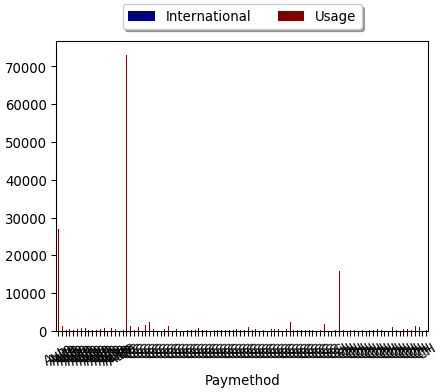

In [8]:
from pixiedust.display import *
display(data)

### Step 6: Build the Spark pipeline and the Random Forest model
"Pipeline" is an API in SparkML that's used for building models.
Additional information on SparkML: https://spark.apache.org/docs/2.0.2/ml-guide.html

In [9]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorIndexer, IndexToString
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier

# Prepare string variables so that they can be used by the decision tree algorithm
# StringIndexer encodes a string column of labels to a column of label indices
SI1 = StringIndexer(inputCol='Gender', outputCol='GenderEncoded')
SI2 = StringIndexer(inputCol='Status',outputCol='StatusEncoded')
SI3 = StringIndexer(inputCol='CarOwner',outputCol='CarOwnerEncoded')
SI4 = StringIndexer(inputCol='Paymethod',outputCol='PaymethodEncoded')
SI5 = StringIndexer(inputCol='LocalBilltype',outputCol='LocalBilltypeEncoded')
SI6 = StringIndexer(inputCol='LongDistanceBilltype',outputCol='LongDistanceBilltypeEncoded')
labelIndexer = StringIndexer(inputCol='CHURN', outputCol='label').fit(data)

#Apply OneHotEncoder so categorical features aren't given numeric importance
OH1 = OneHotEncoder(inputCol="GenderEncoded", outputCol="GenderEncoded"+"classVec")
OH2 = OneHotEncoder(inputCol="StatusEncoded", outputCol="StatusEncoded"+"classVec")
OH3 = OneHotEncoder(inputCol="CarOwnerEncoded", outputCol="CarOwnerEncoded"+"classVec")
OH4 = OneHotEncoder(inputCol="PaymethodEncoded", outputCol="PaymethodEncoded"+"classVec")
OH5 = OneHotEncoder(inputCol="LocalBilltypeEncoded", outputCol="LocalBilltypeEncoded"+"classVec")
OH6 = OneHotEncoder(inputCol="LongDistanceBilltypeEncoded", outputCol="LongDistanceBilltypeEncoded"+"classVec")


# Pipelines API requires that input variables are passed in  a vector
assembler = VectorAssembler(inputCols=["GenderEncodedclassVec", "StatusEncodedclassVec", "CarOwnerEncodedclassVec", "PaymethodEncodedclassVec", "LocalBilltypeEncodedclassVec", \
                                       "LongDistanceBilltypeEncodedclassVec", "Children", "EstIncome", "Age", "LongDistance", "International", "Local",\
                                      "Dropped","Usage","RatePlan"], outputCol="features")

In [10]:
# instantiate the algorithm, take the default settings
rf=RandomForestClassifier(labelCol="label", featuresCol="features")

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=labelIndexer.labels)

pipeline = Pipeline(stages=[SI1,SI2,SI3,SI4,SI5,SI6,labelIndexer, OH1, OH2, OH3, OH4, OH5, OH6, assembler, rf, labelConverter])

In [11]:
# Split data into train and test datasets
train, test = data.randomSplit([0.8,0.2], seed=6)
train.cache()
test.cache()

DataFrame[ID: int, Gender: string, Status: string, Children: double, EstIncome: double, CarOwner: string, Age: double, LongDistance: double, International: double, Local: double, Dropped: double, Paymethod: string, LocalBilltype: string, LongDistanceBilltype: string, Usage: double, RatePlan: double, CHURN: string]

In [12]:
# Build models
model = pipeline.fit(train)

### Step 7: Score the test data set

In [13]:
results = model.transform(test)
results=results.select(results["ID"],results["CHURN"],results["label"],results["predictedLabel"],results["prediction"],results["probability"])
results.toPandas().head(6)

,ID,CHURN,label,predictedLabel,prediction,probability
0,14,F,0.0,F,0.0,"[0.917814110507, 0.0821858894927]"
1,18,F,0.0,F,0.0,"[0.591030505495, 0.408969494505]"
2,21,F,0.0,F,0.0,"[0.738936366721, 0.261063633279]"
3,22,F,0.0,F,0.0,"[0.651376119848, 0.348623880152]"
4,29,T,1.0,T,1.0,"[0.308803780697, 0.691196219303]"
5,40,T,1.0,T,1.0,"[0.13862165487, 0.86137834513]"


### Step 8: Model Evaluation 

In [24]:
#print 'Precision model1 = {:.2f}.'.format(results.filter(results.label == results.prediction).count() / float(results.count()))
print("Precision model1 = ", format(results.filter(results.label == results.prediction).count() / float(results.count())))

Precision model1 =  0.9300699300699301


In [23]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="label", metricName="areaUnderROC")
#print 'Area under ROC curve = {:.2f}.'.format(evaluator.evaluate(results))
print("Area under ROC curve = ", evaluator.evaluate(results))

Area under ROC curve =  0.9241126070991433


We have finished building and testing a predictive model. The next step is to deploy it. In production environment the model can be deployed for batch or real time scoring. The following steps explain how to deploy a model for real time scoring.

### Step 9: Save Model in ML repository

** You need to have an IBM Cloud account and create a **Watson Machine Learning** service to complete the rest of the steps. If you don't have the account, please ask the instructor to show a demo.

In this section you will store your model in the Watson Machine Learning (WML) repository by using Python client libraries.
* <a href="https://console.ng.bluemix.net/docs/services/PredictiveModeling/index.html">WML Documentation</a>
* <a href="http://watson-ml-api.mybluemix.net/">WML REST API</a> 
* <a href="https://watson-ml-staging-libs.mybluemix.net/repository-python/">WML Repository API</a>
<br/>

First, you must import client libraries.

In [26]:
from repository.mlrepositoryclient import MLRepositoryClient
from repository.mlrepositoryartifact import MLRepositoryArtifact

Put your authentication information from your instance of the Watson Machine Learning service in <a href="https://console.ng.bluemix.net/dashboard/apps/" target="_blank">Bluemix</a> in the next cell. You can find your information in the **Service Credentials** tab of your service instance in Bluemix.

![WML Credentials](https://raw.githubusercontent.com/yfphoon/IntroToWML/master/images/WML%20Credentials.png)

<span style="color:red">Replace the service_path and credentials with your own information</span>

service_path=[your url]<br/>
instance_id=[your instance_id]<br/>
username=[your username]<br/>
password=[your password]<br/>


{
  "apikey": "D2HOPDsxhZE310Dc5dP9p8xO3M3o5VH7bChSJuOGJeMI",
  "iam_apikey_description": "Auto generated apikey during resource-key operation for Instance - crn:v1:bluemix:public:pm-20:us-south:a/9422ff80452f78fb8ea770fa189199c2:76075c55-c628-45c5-9de4-143fbd42238d::",
  "iam_apikey_name": "auto-generated-apikey-5ac9555e-631b-486c-b484-7d6e556c97e3",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/9422ff80452f78fb8ea770fa189199c2::serviceid:ServiceId-3fe46d72-be4c-41da-895c-f5c98ca0b61c",
  "instance_id": "76075c55-c628-45c5-9de4-143fbd42238d",
  "password": "78c4c71e-5eae-4ccd-926d-d8a40c264d18",
  "url": "https://us-south.ml.cloud.ibm.com",
  "username": "5ac9555e-631b-486c-b484-7d6e556c97e3"
}

In [27]:
# @hidden_cell
service_path = 'https://us-south.ml.cloud.ibm.com'
instance_id = '76075c55-c628-45c5-9de4-143fbd42238d'
username = '5ac9555e-631b-486c-b484-7d6e556c97e3'
password = '78c4c71e-5eae-4ccd-926d-d8a40c264d18'

In [28]:
# Authorize the repository client
ml_repository_client = MLRepositoryClient(service_path)
ml_repository_client.authorize(username, password)

Create the model artifact and save it in the repository.

<b>Tip:</b> The MLRepositoryArtifact method expects a trained model object, training data, and a model name. (It is this model name that is displayed by the Watson Machine Learning service).


In [30]:
model_artifact = MLRepositoryArtifact(model, training_data=train, name="Predict Customer Churn")
saved_model = ml_repository_client.models.save(model_artifact)

# Print the saved model properties
print ("modelType: ", saved_model.meta.prop("modelType"))
print ("creationTime: ", str(saved_model.meta.prop("creationTime")))
print ("modelVersionHref: ", saved_model.meta.prop("modelVersionHref"))
print ("label: ", saved_model.meta.prop("label"))

modelType:  sparkml-model-2.3
creationTime:  2018-10-12 11:20:18.349000+00:00
modelVersionHref:  https://us-south.ml.cloud.ibm.com/v2/artifacts/models/e84f1e89-4424-4d5d-8d69-23747bc6098d/versions/31a4c64f-bed0-4f19-834b-a85ba6deb816
label:  CHURN


### Step 10:  Deploy and Test model with UI

1. Save the notebook and switch to the **Assets** tab of the project (hint: open with another tab in your browser). 
2. Under **Watson Machine Learning Models**, find and click into your deployed model named `Predict Customer Churn`. Add an **Online deployment** clicking on the **Action** menu and **Deploy**.
3. Add a **new deployment** 
4. Upon successful completion, click **View**
5. Click on the **Test** tab to test the model. 

You can use the following data for testing: ID=99, Gender=M, Status=S, Children=0, Est Income=60000, Car Owner=Y, Age=34, LongDistance=68, International=50, Local=100, Dropped=0, Paymethod=CC, LocalBilltype=Budget, LongDistanceBilltype=Intnl_discount, Usage=334, RatePlan=3

The results of the test is displayed as follows:<br/>
<img style="float: left;" src="https://github.com/cllebrun/ws-cloud-datascience/blob/master/labs/2.%20Lab%20Datascience%20-%20Watson%20Studio/images_2/TestResults.png" alt="Test API" width=900 />

### Summary

You have finished working on this hands-on lab. In this notebook you created a model using SparkML API, deployed it in  Machine Learning service for online (real time) scoring and tested it using a test client. 


Created by **Sidney Phoon** and **Elena Lowery**
<br/>
yfphoon@us.ibm.com
elowery@us.ibm.com
<br/>
July 25, 2017

Modified by **Emmanuel Génard**
<br/>
genard@fr.ibm.com
<br/>
October 11, 2018